# MISSION : 토닥토닥봇 만들기💚









## #0. 실습 준비하기

먼저 구글 드라이브를 마운트하고, 1일차에서 코딩했던 전처리 코드가 들어있는 utils.py를 불러오겠습니다.

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

!cp "/content/gdrive/My Drive/NLP/utils.py" "/content"

Mounted at /content/gdrive


필요하실 수 있는 라이브러리들도 로딩했어요.

In [2]:
!pip install konlpy

import numpy as np
import tensorflow as tf

     |████████████████████████████████| 19.4MB 1.3MB/s 
     |████████████████████████████████| 3.8MB 57.8MB/s 
     |████████████████████████████████| 92kB 11.2MB/s 
  Found existing installation: tweepy 3.6.0
    Uninstalling tweepy-3.6.0:
      Successfully uninstalled tweepy-3.6.0
  Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3


## #1. 데이터셋 불러오기


In [3]:
import json
filename = "/content/gdrive/My Drive/NLP/Wellness_data_train.json"

with open(filename) as f:
  train = json.loads(f.read())
print("# of Train =", len(train))

# of Train = 4651


👉 총 4,651건의 (인풋 - 라벨) 쌍의 학습용 데이터가 있습니다.

In [4]:
print("Data Example")
for i in range(5):
  print(train[i])

Data Example
['Sent_4393', '뭔가 하루종일 이렇게 들뜬 기분이다 보니까 잠도 잘 안 와.', '증상/불면', '증상/불면']
['Sent_603', '아무한테나 화내고 그러지는 않아.', '감정/분노', '감정/분노']
['Sent_4224', '잠자리에 누워도 맨날 뒤척이고... 잠을 제대로 잘 수 있을 리가 없지.', '증상/불면', '증상/불면']
['Sent_3849', '5일 전에는 새벽에 일어나서 화장실을 가다가 순간적으로 정신을 잃었어.', '증상/기절', '증상/기절']
['Sent_666', '그냥 감정이입이 심하게 되고 불안감도 잘 느끼는 것 같아요.', '감정/불안감', '감정/불안감']


👉 학습 데이터의 첫 번째 다섯 개의 example들을 프린트해보았습니다.   
👉 리스트의 0번째에 문장_id, 1번째에 인풋 텍스트, 2번째에 정답 라벨이 있는 것을 확인할 수 있습니다.   
👉 3번째에 있는 것은 2번째에 있는 카테고리보다 세분화된 라벨로, 이번 태스크에서는 무시하셔도 좋습니다.

In [5]:
import collections
train_counter = collections.Counter()
for dat in train:
  train_counter[dat[2]] += 1
print("라벨 개수:", len(train_counter), "\n")
print("*** LABEL 분포 ***")

for cnt in train_counter.most_common():
  print("{} : {} ({:.2f}%)".format(cnt[0], cnt[1], 100*cnt[1]/len(train)))

라벨 개수: 176 

*** LABEL 분포 ***
증상/불면 : 236 (5.07%)
배경/직장 : 152 (3.27%)
배경/남편 : 142 (3.05%)
감정/걱정 : 134 (2.88%)
배경/부모 : 125 (2.69%)
감정/힘듦 : 111 (2.39%)
배경/생활 : 107 (2.30%)
배경/성격 : 94 (2.02%)
감정/불안감 : 91 (1.96%)
감정/우울감 : 87 (1.87%)
감정/자살충동 : 87 (1.87%)
증상/무기력 : 87 (1.87%)
감정/부정적사고 : 86 (1.85%)
증상/피해망상 : 82 (1.76%)
증상/식욕저하 : 67 (1.44%)
배경/건강문제 : 65 (1.40%)
배경/남자친구 : 60 (1.29%)
증상/반복행동 : 59 (1.27%)
배경/학교 : 56 (1.20%)
배경/문제 : 55 (1.18%)
배경/음주 : 53 (1.14%)
감정/답답 : 51 (1.10%)
배경/대학 : 48 (1.03%)
배경/연애 : 47 (1.01%)
감정/짜증 : 46 (0.99%)
배경/경제적문제 : 46 (0.99%)
배경/사업 : 45 (0.97%)
증상/기억력저하 : 45 (0.97%)
증상/호흡곤란 : 44 (0.95%)
배경/여자친구 : 41 (0.88%)
치료이력/병원내원 : 40 (0.86%)
증상/두통 : 39 (0.84%)
증상/두근거림 : 37 (0.80%)
배경/친구 : 37 (0.80%)
배경/어린시절 : 35 (0.75%)
감정/화 : 35 (0.75%)
증상/환청 : 34 (0.73%)
배경/대인관계 : 33 (0.71%)
부가설명 : 33 (0.71%)
증상/은둔 : 32 (0.69%)
감정/심란 : 31 (0.67%)
증상/통증 : 31 (0.67%)
배경/취업 : 30 (0.65%)
배경/결혼 : 30 (0.65%)
배경/가족 : 30 (0.65%)
감정/후회 : 30 (0.65%)
감정/눈물 : 29 (0.62%)
배경/시댁 : 29 (0.62%)
배경/자녀 : 29 (0.6

👉 우리가 만들 NLU 텍스트 분류 모델이 어떤 카테고리를 예측해야 하는지 프린트해보았습니다.   
👉 각각의 라벨 이름과 그에 해당하는 데이터 개수와 그 비율이 나와 있습니다.   
👉 증상/불면과 같은 카테고리는 239개나 되는 예시 문장이 있지만, 원인/없음과 같은 카테고리는 5개밖에 문장이 없는 것을 볼 수 있습니다.

## #2. NLU 모델링

그럼, train 데이터셋을 사용해 176가지 감정 카테고리 분류 모델 학습을 시작해보세요!   

NLU 모델링을 위한 4가지 프로세스:   
토크나이징 - 인코딩 - 토큰 임베딩 -모델링

기억하고 계시지요:)?

참고로 각각의 스텝에서 결정하고, 코딩해야 할 것들은 다음과 같습니다. 
1. 토크나이징   
a. 어떤 단위의 토큰을 사용할 것인가? (형태소/ 글자)   
b. tokenize(sentence) 함수 정의하기   
c. 학습 데이터에 있는 문장 토크나이즈하기

2. 인코딩   
a. 단어사전 만들기   
  - 형태소 단위라면 -> CBOW 워드벡터 사용할지/ 처음부터 만들지 결정
  - 글자 단위라면 -> 학습 데이터에 등장한 글자들로 구성된 단어사전 만들기   

  b. text_encoder 만들기(TextEncoder 사용)   
  c. 토크나이징된 문장을 text_encoder를 사용해 인덱스로 변환하고, 모델 학습에 필요한 train_ids, train_labels 만들기 (create_cls_feature 함수 활용)   

--- 여기부터 모델링 ---
3. 임베딩   
4. 모델링   
a. 아키텍처 결정하기 (RNN? CNN? 하이퍼파라미터?)   
b. CBOW 워드 벡터를 사용하기로 했다면, Embedding Weight 초기화하기   
c. 모델 컴파일 (loss, optimizer, metrics)    
d. 모델 학습 (epoch 수 조절, EarlyStopping 등)



<font size=20> YOUR CODE HERE </font>

In [6]:
from konlpy.tag import Komoran, Hannanum, Kkma, Okt

In [7]:
from utils import TextEncoder, create_cls_feature

#### Step 1. 토크나이징
CBOW 워드벡터를 활용하기 위해 Komoran 형태소분석기를 사용하겠습니다.


In [8]:
komoran = Komoran()
def tokenize(sentence):
  return komoran.morphs(sentence)

#### Step 2. 인코딩

단어사전 로딩하기

In [9]:
""" 지난 실슬 때 만들었던 단어 사전 로딩 """
## 저장한 파일 로딩
import numpy as np
with open("/content/gdrive/My Drive/NLP/vecs.tsv") as f:
  vecs = [v.strip() for v in f.readlines()]
final_embeddings = [v.split("\t") for v in vecs]
final_embeddings = np.array(final_embeddings, dtype="float32")
with open("/content/gdrive/My Drive/NLP/meta.tsv") as f:
  vocab_list = [v.strip() for v in f.readlines()]

print(len(vocab_list))

70002


현재 Train Data에서 OOV로 떨어지는 토큰 확인하고 사전에 추가하기

In [10]:
tot_tokens = 0
oov_counter = collections.Counter()
Tokenized_train = []
for dat in train:
  sent = dat[1]
  tokenized_sent = tokenize(sent)
  tot_tokens += len(tokenized_sent)
  for word in tokenized_sent:
    if word not in vocab_list:
      oov_counter[word] += 1
  Tokenized_train.append([dat[0], tokenized_sent, dat[2]])

In [11]:
print("# OOV Tokens:", len(oov_counter))
print("{}/{} ({:.2f}%) are [UNK] in train tokens".format(sum(oov_counter.values()) , tot_tokens , 100*sum(oov_counter.values())/tot_tokens))

# OOV Tokens: 471
838/74665 (1.12%) are [UNK] in train tokens


In [12]:
### 새로 나온 데이터 살펴보기
most_common = oov_counter.most_common(len(oov_counter))
print(most_common[:10])
print(most_common[-10:])

### Train 데이터에서 새로 발견한 토큰을 기존 단어 사전에 추가
new_vocab_list = vocab_list.copy()
new_vocab_list.extend([v[0] for v in most_common])
print("\n# New Vocabs = {}".format(len(new_vocab_list)))

##TEMP
print(new_vocab_list[:30])

[('걔', 37), ('더라구', 20), ('어떡하지', 17), ('여치', 13), ('대요', 13), ('두근거리', 13), ('뒤척이', 12), ('갑갑', 12), ('아파서', 10), ('얼른', 8)]
[('버럭', 1), ('아차', 1), ('싱숭생숭하네요…', 1), ('대견', 1), ('돌덩이', 1), ('쭈꾸미를', 1), ('혹시나', 1), ('헷갈려요.', 1), ('근육통', 1), ('볼링공', 1)]

# New Vocabs = 70473
['[PAD]', '[UNK]', '하', '이', '.', '의', '는', '을', '다', 'ㄴ', '에', ',', '았', '은', '를', '었', '고', '되', '아', '에서', '가', '으로', '있', '들', '로', ')', '어', '(', '년', '과']


In [13]:
text_encoder = TextEncoder(new_vocab_list)

모델 인풋 만들기

In [14]:
MAX_LEN = 50
train_ids, train_labels, label_map = create_cls_feature(Tokenized_train, text_encoder, max_seq_len=MAX_LEN)
label_map

** 4651 examples processed


{'감정/감정조절이상': 29,
 '감정/걱정': 13,
 '감정/고독감': 127,
 '감정/곤혹감': 172,
 '감정/공포': 104,
 '감정/공허감': 56,
 '감정/과민반응': 147,
 '감정/괴로움': 90,
 '감정/기분저하': 101,
 '감정/기시감': 149,
 '감정/긴장': 117,
 '감정/눈물': 40,
 '감정/답답': 54,
 '감정/당황': 71,
 '감정/두려움': 60,
 '감정/멍함': 153,
 '감정/모호함': 110,
 '감정/무력감': 45,
 '감정/무미건조': 138,
 '감정/무서움': 59,
 '감정/미안함': 150,
 '감정/미움': 140,
 '감정/배신감': 78,
 '감정/부정적사고': 39,
 '감정/분노': 1,
 '감정/불만': 139,
 '감정/불신': 100,
 '감정/불안감': 3,
 '감정/불쾌감': 75,
 '감정/불편감': 31,
 '감정/비관적': 156,
 '감정/살인욕구': 99,
 '감정/생각': 144,
 '감정/서운함': 88,
 '감정/속상함': 62,
 '감정/슬픔': 143,
 '감정/신경쓰임': 80,
 '감정/심란': 53,
 '감정/억울함': 77,
 '감정/예민함': 109,
 '감정/외로움': 11,
 '감정/우울감': 7,
 '감정/의기소침': 119,
 '감정/의욕상실': 102,
 '감정/자괴감': 66,
 '감정/자살충동': 10,
 '감정/자신감저하': 92,
 '감정/자존감저하': 25,
 '감정/절망감': 85,
 '감정/좌절': 43,
 '감정/죄책감': 154,
 '감정/즐거움': 72,
 '감정/짜증': 21,
 '감정/창피함': 170,
 '감정/초조함': 174,
 '감정/충격': 94,
 '감정/통제력상실': 63,
 '감정/허무함': 151,
 '감정/화': 93,
 '감정/후회': 130,
 '감정/힘듦': 55,
 '내원이유/상담': 132,
 '내원이유/의사소견': 161,
 '내원이유/치료': 89,
 '배경/가족': 35,

Train 데이터는 train / validation으로 나눠서 학습에 활용

In [15]:
from sklearn.model_selection import train_test_split
train_ids, val_ids, train_labels, val_labels = train_test_split(train_ids, train_labels , test_size=0.10, random_state=42, stratify=train_labels)

print("# Train={} # Val={}".format(len(train_ids), len(val_ids)))

# Train=4185 # Val=466


#### Step 3. 모델 만들기

In [16]:
## CBOW로 사전학습했던 vector 사용
print(final_embeddings.shape)

(70002, 128)


##### 3-1) 모델 구조 만들기

1. Multi-Layer LSTM

In [17]:
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, GRU, Dropout, Dense

vocab_size = text_encoder.vocab_size # 단어사전 개수
embedding_dim = final_embeddings.shape[1] # 임베딩 차원
rnn_hidden_dim = 100 # RNN hidden_size
dense_hidden_dim = 200
final_dim = len(label_map) #176

model1 = tf.keras.Sequential([
    Embedding(vocab_size, embedding_dim, mask_zero=True),
    Bidirectional(GRU(rnn_hidden_dim, return_sequences=False)),
    Dropout(0.5),
    Dense(dense_hidden_dim, activation="relu"),
    Dropout(0.5),
    Dense(final_dim, activation='softmax')
]) ## CODE

In [18]:
## CBOW Weight Assign
import random
org_vocab_size = final_embeddings.shape[0]

rand_initial = np.random.uniform(-1,1,size=[vocab_size-org_vocab_size,embedding_dim])
initial_weight = np.append(final_embeddings, rand_initial, axis = 0)
initial_weight.shape

model1.weights[0].assign(initial_weight)
model1.get_weights()[0]

array([[-1.28351338e-02,  3.81695963e-02,  1.28244273e-02, ...,
        -4.17494550e-02, -6.71934336e-04, -2.51525883e-02],
       [-4.32882756e-02, -2.28408545e-01, -3.32357734e-01, ...,
        -6.22151256e-01, -2.18298435e-01,  5.55368602e-01],
       [ 1.45662999e+00, -6.75910652e-01,  2.81228483e-01, ...,
         5.91976941e-01, -2.66387731e-01, -5.20118475e-01],
       ...,
       [ 1.46310121e-01, -8.74729216e-01,  8.57107818e-01, ...,
        -9.05239642e-01, -4.79493171e-01,  1.89331565e-02],
       [-8.74566138e-01, -6.85813725e-01,  1.10719785e-01, ...,
        -2.47535020e-01,  7.41969883e-01, -4.31587458e-01],
       [-3.01219851e-01,  5.45428991e-01,  1.40715614e-02, ...,
         5.38201392e-01,  8.70580018e-01, -9.68216300e-01]], dtype=float32)

In [19]:
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 128)         9020544   
_________________________________________________________________
bidirectional (Bidirectional (None, 200)               138000    
_________________________________________________________________
dropout (Dropout)            (None, 200)               0         
_________________________________________________________________
dense (Dense)                (None, 200)               40200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 176)               35376     
Total params: 9,234,120
Trainable params: 9,234,120
Non-trainable params: 0
______________________________________________

2. CNN

In [20]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense

vocab_size = text_encoder.vocab_size # 단어사전 개수
embedding_dim = final_embeddings.shape[1] # 임베딩 차원
cnn_filters = [2,3,4,5]
num_feature_map = 32

## character embedding 적용
input_ = tf.keras.layers.Input(shape=(None,))
x =  Embedding(vocab_size, embedding_dim, mask_zero = True)(input_)

## apply CNN filters
result_cnns = []
for i, kernel in enumerate(cnn_filters):
  temp = Conv1D(filters = num_feature_map, 
                    kernel_size = kernel, activation='relu')(x)
  temp = GlobalMaxPooling1D()(temp)
  result_cnns.append(temp)

## concatenate to feature map
x = tf.keras.layers.concatenate(result_cnns, axis=-1)

## 긍정/ 부정 분류하는 FCN 연결하기
x = Dropout(0.5)(x)
labels = Dense(final_dim, activation="softmax")(x)

model2 = tf.keras.Model(inputs=input_, outputs = labels)

In [21]:
## CBOW Weight Assign
model2.weights[0].assign(initial_weight)
model2.get_weights()[0]

array([[-1.28351338e-02,  3.81695963e-02,  1.28244273e-02, ...,
        -4.17494550e-02, -6.71934336e-04, -2.51525883e-02],
       [-4.32882756e-02, -2.28408545e-01, -3.32357734e-01, ...,
        -6.22151256e-01, -2.18298435e-01,  5.55368602e-01],
       [ 1.45662999e+00, -6.75910652e-01,  2.81228483e-01, ...,
         5.91976941e-01, -2.66387731e-01, -5.20118475e-01],
       ...,
       [ 1.46310121e-01, -8.74729216e-01,  8.57107818e-01, ...,
        -9.05239642e-01, -4.79493171e-01,  1.89331565e-02],
       [-8.74566138e-01, -6.85813725e-01,  1.10719785e-01, ...,
        -2.47535020e-01,  7.41969883e-01, -4.31587458e-01],
       [-3.01219851e-01,  5.45428991e-01,  1.40715614e-02, ...,
         5.38201392e-01,  8.70580018e-01, -9.68216300e-01]], dtype=float32)

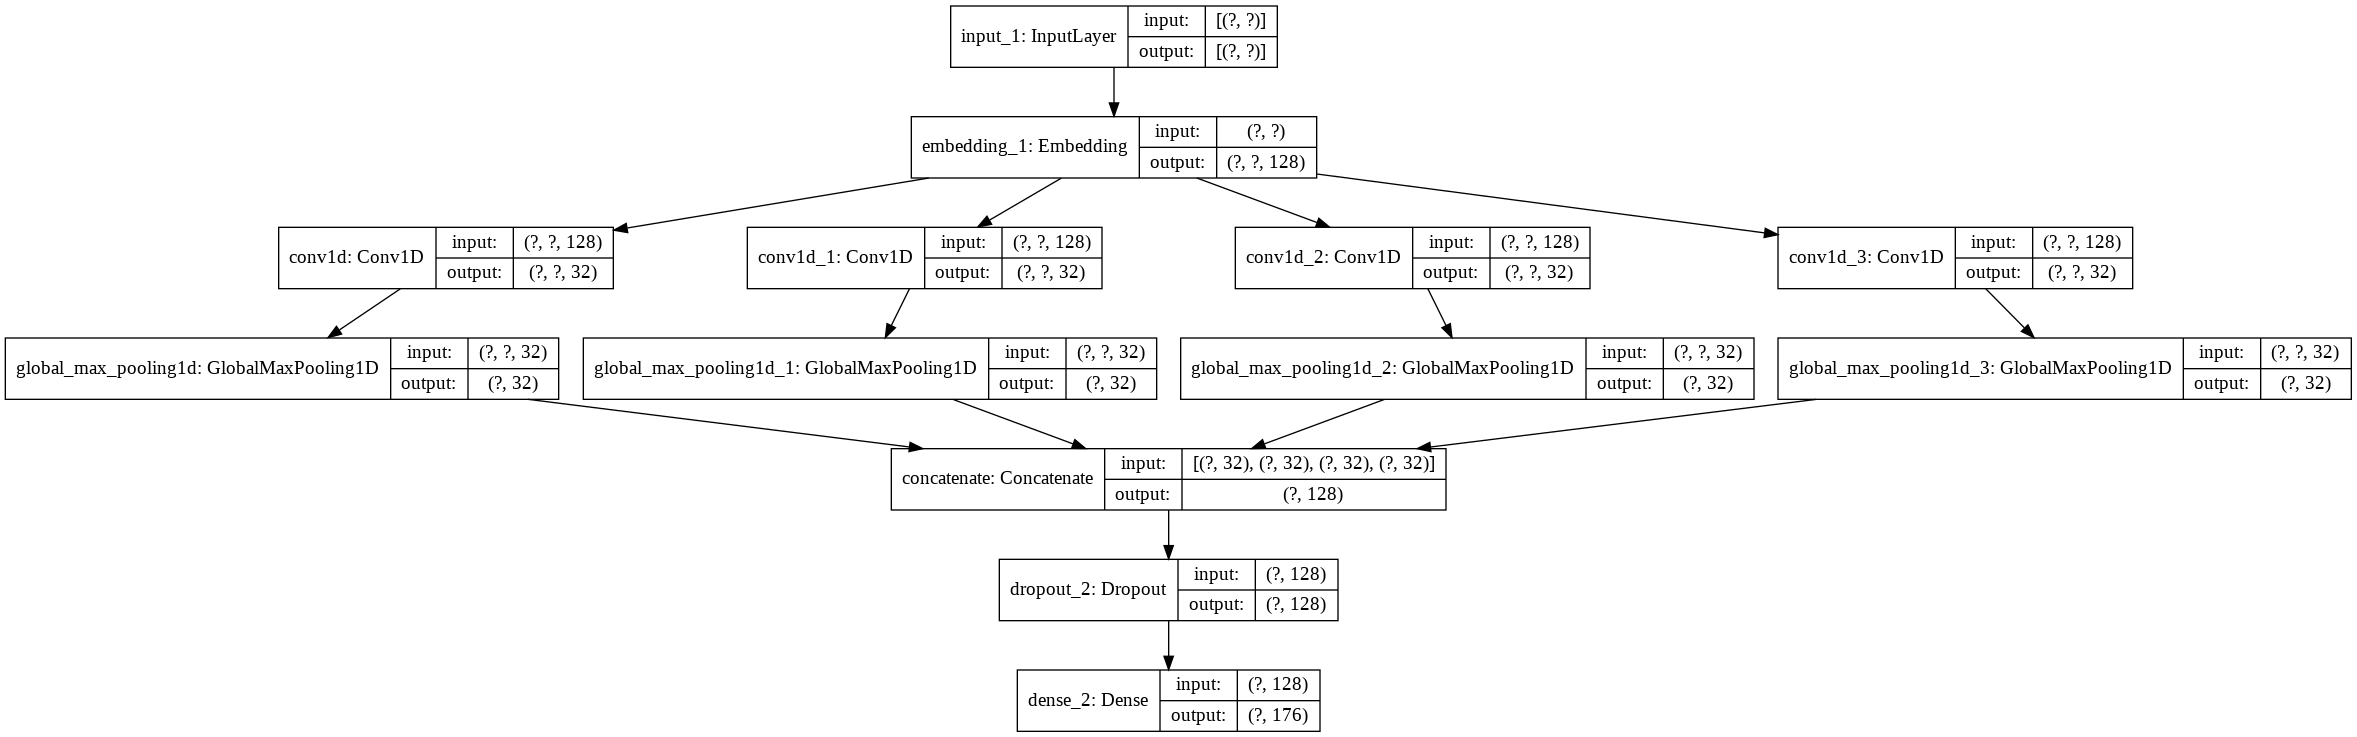

In [22]:
tf.keras.utils.plot_model(
    model2, to_file='model.png', show_shapes=True)

##### 3-2) 모델 컴파일

In [23]:
model1.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model2.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

##### 3-3) 모델 학습

In [24]:
num_epochs = 50
callback = tf.keras.callbacks.EarlyStopping( monitor='val_loss', patience=2)
history1 = model1.fit(train_ids, train_labels, epochs=num_epochs, 
                    validation_data=(val_ids, val_labels), verbose=1, batch_size = 100,
                    callbacks = [callback])

Epoch 1/50
42/42 [==============================] - 7s 173ms/step - loss: 4.9845 - accuracy: 0.0332 - val_loss: 4.7413 - val_accuracy: 0.0601
Epoch 2/50
42/42 [==============================] - 3s 60ms/step - loss: 4.7269 - accuracy: 0.0609 - val_loss: 4.6606 - val_accuracy: 0.0794
Epoch 3/50
42/42 [==============================] - 3s 60ms/step - loss: 4.5928 - accuracy: 0.0836 - val_loss: 4.5473 - val_accuracy: 0.1030
Epoch 4/50
42/42 [==============================] - 3s 60ms/step - loss: 4.4239 - accuracy: 0.1154 - val_loss: 4.4287 - val_accuracy: 0.1137
Epoch 5/50
42/42 [==============================] - 3s 71ms/step - loss: 4.2329 - accuracy: 0.1422 - val_loss: 4.2964 - val_accuracy: 0.1481
Epoch 6/50
42/42 [==============================] - 3s 61ms/step - loss: 4.0616 - accuracy: 0.1601 - val_loss: 4.1807 - val_accuracy: 0.1567
Epoch 7/50
42/42 [==============================] - 3s 60ms/step - loss: 3.8737 - accuracy: 0.1902 - val_loss: 4.0433 - val_accuracy: 0.1760
Epoch 8/50
4

In [25]:
num_epochs = 50
callback2 = tf.keras.callbacks.EarlyStopping( monitor='val_loss', patience=2)
history2 = model2.fit(train_ids, train_labels, epochs=num_epochs, 
                    validation_data=(val_ids, val_labels), verbose=1, batch_size = 100, callbacks = [callback])

Epoch 1/50
42/42 [==============================] - 3s 67ms/step - loss: 5.2883 - accuracy: 0.0265 - val_loss: 4.7064 - val_accuracy: 0.0622
Epoch 2/50
42/42 [==============================] - 2s 57ms/step - loss: 4.7630 - accuracy: 0.0530 - val_loss: 4.6453 - val_accuracy: 0.0751
Epoch 3/50
42/42 [==============================] - 2s 58ms/step - loss: 4.6056 - accuracy: 0.0786 - val_loss: 4.5830 - val_accuracy: 0.0944
Epoch 4/50
42/42 [==============================] - 2s 58ms/step - loss: 4.4585 - accuracy: 0.1054 - val_loss: 4.5206 - val_accuracy: 0.1180
Epoch 5/50
42/42 [==============================] - 2s 57ms/step - loss: 4.3283 - accuracy: 0.1219 - val_loss: 4.4488 - val_accuracy: 0.1223
Epoch 6/50
42/42 [==============================] - 2s 56ms/step - loss: 4.1872 - accuracy: 0.1491 - val_loss: 4.3705 - val_accuracy: 0.1288
Epoch 7/50
42/42 [==============================] - 2s 55ms/step - loss: 4.0515 - accuracy: 0.1735 - val_loss: 4.2842 - val_accuracy: 0.1567
Epoch 8/50
42

## #3. 테스트 데이터에서의 성능 평가하기

In [26]:
filename = "/content/gdrive/My Drive/NLP/Wellness_data_test.json"

with open(filename) as f:
  test = json.loads(f.read())
print("# of Test =", len(test))

# of Test = 400


<font color="red"> test 데이터에 대해 학습 데이터 전처리에 사용한 tokenizer과 text_encoder를 사용해 test_ids와 test_labels를 만드세요

In [27]:
## 예시 코드
MAX_LEN = 50
Tokenized_text = []
for dat in test:
  Tokenized_text.append([dat[0], tokenize(dat[1]), dat[2]])

test_ids, test_labels, _ = create_cls_feature(Tokenized_text, text_encoder, max_seq_len=MAX_LEN, label_map = label_map)

** Start creating features using label map
{'증상/불면': 0, '감정/분노': 1, '증상/기절': 2, '감정/불안감': 3, '증상/두근거림': 4, '배경/건강문제': 5, '배경/취업': 6, '감정/우울감': 7, '배경/대인관계': 8, '배경/어린시절': 9, '감정/자살충동': 10, '감정/외로움': 11, '증상/자살시도': 12, '감정/걱정': 13, '배경/학업': 14, '증상/무기력': 15, '증상/식욕저하': 16, '일반대화': 17, '배경/결혼': 18, '상태/증상지속': 19, '배경/학교': 20, '감정/짜증': 21, '배경/부모': 22, '증상/두통': 23, '증상/피해망상': 24, '감정/자존감저하': 25, '배경/성격': 26, '증상/기억상실': 27, '배경/사업': 28, '감정/감정조절이상': 29, '배경/전연인': 30, '감정/불편감': 31, '배경/경제적문제': 32, '치료이력/병원내원': 33, '배경/친구': 34, '배경/가족': 35, '배경/여자친구': 36, '치료이력/검사': 37, '증상/어지러움': 38, '감정/부정적사고': 39, '감정/눈물': 40, '배경/시댁': 41, '증상/반복행동': 42, '감정/좌절': 43, '배경/자녀': 44, '감정/무력감': 45, '배경/사고': 46, '배경/직장': 47, '증상/기억력저하': 48, '증상/은둔': 49, '증상/환청': 50, '증상/이명': 51, '부가설명': 52, '감정/심란': 53, '감정/답답': 54, '감정/힘듦': 55, '감정/공허감': 56, '배경/남편': 57, '증상/반복사고': 58, '감정/무서움': 59, '감정/두려움': 60, '증상/피로': 61, '감정/속상함': 62, '감정/통제력상실': 63, '배경/생활': 64, '배경/종교': 65, '감정/자괴감': 66, '증상/환각': 67, '배경/음주': 68, '배경/대학

<font color="red"> test_ids를 인풋으로 받아 predictions를 생성하는 make_prediction 코드입니다.   
필요한 경우, 수정한 후 아래의 코드를 실행해보세요!

In [28]:
def make_prediction(test_ids):
  model_result1 = model1.predict(test_ids)
  model_result2 = model2.predict(test_ids)

  ## 앙상블
  scores = (model_result1 + model_result2) / 2 
  predictions = np.argmax(scores, axis=1)
  return scores , predictions

In [29]:
def SCORE(predictions, ground_truth):
  print("TEST SET ACCURACY: {:.2f}".format(sum(predictions == ground_truth) / len(predictions)))
  print("-"*80)
  label_reverse = {v:k for k, v in label_map.items()}
  for i in range(len(predictions)):
    if predictions[i] != ground_truth[i]:
      print("🥺: {}".format(test[i][1]))
      print("-> 👩‍⚕️: {} 🤖: {}".format( label_reverse[ground_truth[i]], label_reverse[predictions[i]]), "\n")
      

In [30]:
scores, predictions = make_prediction(test_ids)

SCORE(predictions, test_labels)

TEST SET ACCURACY: 0.42
--------------------------------------------------------------------------------
🥺: 저는 이제 망했어요…
-> 👩‍⚕️: 감정/좌절 🤖: 감정/충격 

🥺: 스테로이드를 먹으니까 불면이 더 심해진 것 같아.
-> 👩‍⚕️: 증상/불면 🤖: 배경/건강문제 

🥺: 맛있는 거 먹으면 괜찮아졌는데, 요즘은 아니에요.
-> 👩‍⚕️: 증상/식욕저하 🤖: 증상/불면 

🥺: 이상하게 사고도 자꾸 생기는 것 같고…
-> 👩‍⚕️: 배경/사고 🤖: 증상/환청 

🥺: 나도 근속을 좀 해보고 싶다.
-> 👩‍⚕️: 배경/직장 🤖: 증상/피해망상 

🥺: 2년정도 지나니까 빈털터리가 되있었어요.
-> 👩‍⚕️: 배경/경제적문제 🤖: 배경/사고 

🥺: 근데 의사가 그 외에 또 뭐 없는지 자세하게 말해달라고 하는 거야.
-> 👩‍⚕️: 치료이력/병원내원 🤖: 증상/불면 

🥺: 안심이 안 된다…
-> 👩‍⚕️: 감정/불안감 🤖: 자가치료/심리조절 

🥺: 가만히 있어도 떨리고… 심장 뛰는 소리가 막 들려요.
-> 👩‍⚕️: 증상/가슴떨림 🤖: 증상/두근거림 

🥺: 혼자서 할 수 있는 일도 없고, 내 자신이 너무 한심해…
-> 👩‍⚕️: 감정/자괴감 🤖: 감정/부정적사고 

🥺: 진짜 너무 마려워서 급하게 뛰어 들어갔는데 사람이 있는 거야.
-> 👩‍⚕️: 배경/문제 🤖: 증상/두근거림 

🥺: 시댁에서 저에게 바라는것두 너무 많구.
-> 👩‍⚕️: 배경/시댁 🤖: 배경/음주 

🥺: 두 분이서 같이 장사를 하셨었거든요.
-> 👩‍⚕️: 배경/부모 🤖: 배경/경제적문제 

🥺: 뭘 하든 완벽하게 해야 한다는 주의긴 하지만 그런 줄은 몰랐어요.
-> 👩‍⚕️: 배경/성격 🤖: 배경/남편 

🥺: 밤에는 사람이 적으니까… 그나마 다닐 만한 것 같아.
-> 👩‍⚕️: 증상/대인기피 🤖: 배경/생활 

🥺: 최근에 이직을 했어요.
-> 👩‍⚕️: 배경/직장 🤖: 배경/생활 



## #4. Inference 실행하기

완성된 NLU 모델을 사용해 입력 문장에 대해 답변을 리턴하는 ROBOT_DOCTOR 함수를 직접 실행해보세요!

In [31]:
filename = "/content/gdrive/My Drive/NLP/Wellness_response.json"
with open(filename) as f:
  RESPONSE = json.loads(f.read())

In [32]:
import random
def ROBOT_DOCTOR(sentence, label_map=label_map):
  reverse_label = {v:k for k, v in label_map.items()}
  # 1. tokenizer로 문장 파싱
  parsed_sent = tokenize(sentence)
  input_id1 = []

  # 2. vocab_dict를 이용해 인덱스로 변환
  input_id1 = text_encoder.convert_tokens_to_ids(parsed_sent)
  
  # 단일 문장 추론이기 때문에 패딩할 필요가 없음
  input_id = np.array([input_id1])
  score, prediction = make_prediction(input_id)
  prediction = np.argmax(score[0])
  pred_label = reverse_label[prediction]
  

  print("🥺:", sentence)
  print(" -> 추론한 의도: {} ({:.2f}%)\n".format(pred_label , 100*score[0][prediction]))
  print("💚{}".format(random.choice(RESPONSE[pred_label])))  

In [33]:
ROBOT_DOCTOR("요즘 일이 너무 힘들오...")

🥺: 요즘 일이 너무 힘들오...
 -> 추론한 의도: 감정/힘듦 (98.86%)

💚정말 힘들고 스트레스 받으시겠어요. 따뜻한 물에 샤워를 추천해드릴게요.


In [34]:
ROBOT_DOCTOR("사람 상대하는 것도 귀찮고 집에만 있고 싶다")

🥺: 사람 상대하는 것도 귀찮고 집에만 있고 싶다
 -> 추론한 의도: 증상/무기력 (38.36%)

💚가까운 곳부터 나가보면 어떨까요? 현관, 집 앞 슈퍼 그리고 먼 곳까지 차근차근히요!


In [35]:
ROBOT_DOCTOR("날 닮아서 그런지 딸래미가 공부를 너무 안해요")

🥺: 날 닮아서 그런지 딸래미가 공부를 너무 안해요
 -> 추론한 의도: 배경/시댁 (24.59%)

💚마음이 풀릴 때까지 들어드릴게요.
